In [1]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings,AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR
from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt
from pysindy import EnsembleOptimizer
plt.style.use('ggplot')
import matplotlib as mpl
# mpl.rcParams.update({"text.usetex":True})

In [2]:
exp_data = LorenzExp
initial_state = jnp.array([ -8,8,27.])
dt = 0.025
t_train = jnp.arange(0,10.01,dt)
noise_var = 0.1
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 505
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=29,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

lorenz_sol = expdata.system_sol
t_train = expdata.t_train

In [5]:
true_sigma2 = 0.05
x_vals = jax.vmap(lorenz_sol.evaluate)(t_train)
x_train = x_vals + (
    jnp.sqrt(true_sigma2) * 
    jax.random.normal(jax.random.PRNGKey(32),(len(t_train),3))
)

measurement_vecs = jnp.tile(jnp.eye(3)[:2,:],(int(len(t_train)/2+1),1))[:len(t_train)]
y_obs = jnp.sum(measurement_vecs*x_train,axis=1)

In [ ]:
n_colloc = 500
trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1.
colloc_weight = 1e5
sparsifier = pySindySparsifier(
    STLSQ(threshold = 0.1,alpha = 0.01)
    )

In [45]:
optimizer = AnnealedAlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y','z']
)

model.fit(
    t_train,
    t_colloc = None,
    w_colloc = None,
    partialobs_v = measurement_vecs,
    partialobs_y = y_obs,
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(0.05778475, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 100000.0}
Solving for data_weight = 1.0, colloc_weight = 800.0 beta_reg = 0.008


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 6.424e+06, gradnorm = 4.978e+06, alpha = 45.56, improvement_ratio = 0.1779
Iteration 1, loss = 1.084e+06, gradnorm = 1.158e+07, alpha = 37.97, improvement_ratio = 0.832
Iteration 2, loss = 7.462e+05, gradnorm = 8.998e+06, alpha = 85.43, improvement_ratio = 0.3136
Iteration 3, loss = 1.012e+05, gradnorm = 7.943e+06, alpha = 71.19, improvement_ratio = 0.8711
Iteration 4, loss = 5.04e+04, gradnorm = 1.845e+06, alpha = 71.19, improvement_ratio = 0.5319
Iteration 5, loss = 4.779e+04, gradnorm = 1.939e+06, alpha = 192.2, improvement_ratio = 0.05719
Iteration 100, loss = 15.08, gradnorm = 6.365e+03, alpha = 6.491, improvement_ratio = 0.8032
Iteration 200, loss = 9.312, gradnorm = 971.7, alpha = 0.2438, improvement_ratio = 0.498
Iteration 300, loss = 9.253, gradnorm = 689.7, alpha = 0.2438, improvement_ratio = 0.3195
Iteration 400, loss = 9.238, gradnorm = 175.8, alpha = 0.2438, improvement_ratio = 0.65
Iteration 500, loss = 9.232, gradnorm = 104.2, alpha = 0.1693, improvem

  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 9.245, gradnorm = 112.1, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 9.245, gradnorm = 65.59, alpha = 3.472, improvement_ratio = 1.001
Iteration 2, loss = 9.245, gradnorm = 7.433, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 9.245, gradnorm = 4.273, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 9.245, gradnorm = 4.327, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 9.245, gradnorm = 6.227, alpha = 1.674, improvement_ratio = 0.9997
Iteration 100, loss = 9.244, gradnorm = 42.86, alpha = 0.3245, improvement_ratio = 0.7917
Iteration 200, loss = 9.244, gradnorm = 37.68, alpha = 0.1878, improvement_ratio = 0.7066
Iteration 300, loss = 9.244, gradnorm = 16.64, alpha = 0.1087, improvement_ratio = 0.7481
Iteration 400, loss = 9.244, gradnorm = 3.628, alpha = 0.01463, improvement_ratio = 0.7847
Iteration 465, loss = 9.244, gradnorm = 0.0001526, alpha = 3.649e+04, improvement_ratio = 7.223e+03
Solving for data_weight = 1.0,

  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 9.248, gradnorm = 112.8, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 9.248, gradnorm = 116.6, alpha = 3.472, improvement_ratio = 1.0
Iteration 2, loss = 9.248, gradnorm = 9.641, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 9.248, gradnorm = 4.815, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 9.248, gradnorm = 2.991, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 9.248, gradnorm = 4.166, alpha = 1.674, improvement_ratio = 1.0
Iteration 100, loss = 9.248, gradnorm = 37.86, alpha = 0.2254, improvement_ratio = 0.7382
Iteration 200, loss = 9.248, gradnorm = 16.55, alpha = 0.1304, improvement_ratio = 0.7891
Iteration 300, loss = 9.248, gradnorm = 5.289, alpha = 0.01463, improvement_ratio = 0.7805
Iteration 353, loss = 9.248, gradnorm = 0.001142, alpha = 48.23, improvement_ratio = 6.836e+03
Solving for data_weight = 1.0, colloc_weight = 100000.0 beta_reg = 0.001


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 9.249, gradnorm = 113.0, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 9.249, gradnorm = 42.34, alpha = 3.472, improvement_ratio = 0.9999
Iteration 2, loss = 9.249, gradnorm = 2.933, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 9.249, gradnorm = 1.126, alpha = 2.411, improvement_ratio = 1.001
Iteration 4, loss = 9.249, gradnorm = 0.9082, alpha = 2.009, improvement_ratio = 1.001
Iteration 5, loss = 9.249, gradnorm = 1.395, alpha = 1.674, improvement_ratio = 1.0
Iteration 100, loss = 9.249, gradnorm = 21.28, alpha = 0.1304, improvement_ratio = 0.7491
Iteration 200, loss = 9.249, gradnorm = 7.877, alpha = 0.002835, improvement_ratio = 3.362
Line Search Failed!
Final Iteration Results
Iteration 221, loss = 9.249, gradnorm = 0.002103, alpha = 2.64e+05, improvement_ratio = -2.713e+03
Model after smooth warm start
(x)' = 0.254 1 + -9.738 x + 9.805 y + -0.288 z + 0.033 x^2 + -0.053 x y + -0.077 x z + 0.022 y^2 + 0.070 y z + -0.386 z^2
(y)' = -0.75

In [ ]:
model.print()

(x)' = 0.715 1 + -9.968 x + 9.931 y + 0.439 z
(y)' = -0.497 1 + -0.385 x + -0.971 y + -0.426 z + 0.511 x y + -9.141 x z + 0.130 z^2
(z)' = -8.320 1 + 0.073 y + -2.691 z + 0.139 x y + -0.526 x z


In [52]:
# print(model)

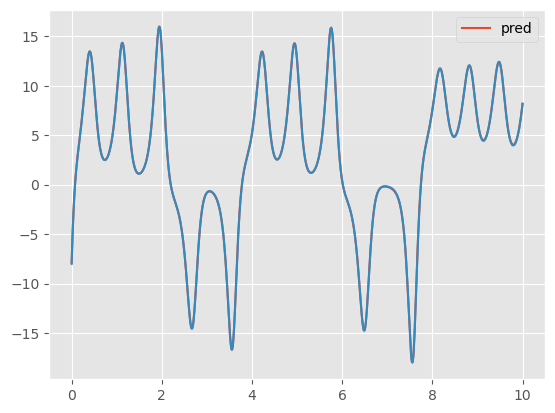

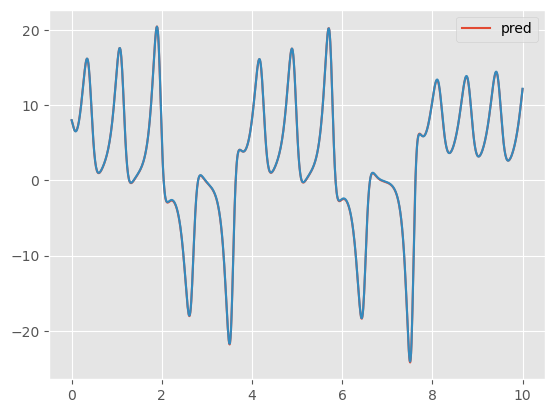

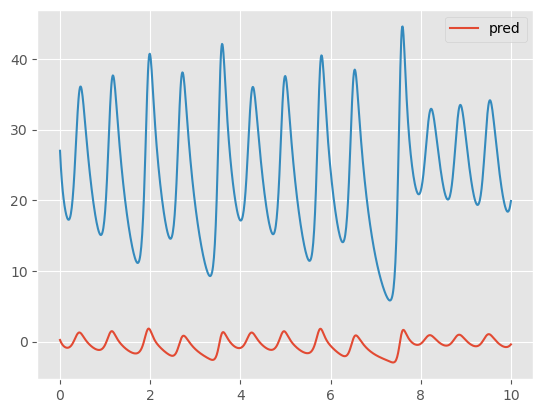

In [47]:
t_grid = jnp.linspace(0,10,1000)
x_pred = model.predict_state(t_grid)
x_grid = jax.vmap(lorenz_sol.evaluate)(t_grid)

for i in range(3):
	plt.plot(t_grid,x_pred[:,i],label = 'pred')
	plt.plot(t_grid,x_grid[:,i])
	plt.legend()
	plt.show()

In [48]:
alt_x0 = model.predict_state(t = jnp.array([9.5]))[0]

In [49]:
def model_ode(t,x,args = None):
    return model.predict(x)

In [50]:
import diffrax

dt0 = 0.005
stepsize_controller = diffrax.PIDController(rtol = 1e-7,atol =1e-7)

save_at = diffrax.SaveAt(dense=True)  # Save at regular intervals
sol = diffrax.diffeqsolve(
	terms = diffrax.ODETerm(model_ode),
	solver = diffrax.Tsit5(),
	t0=9.5,
	t1=20,
	dt0=dt0,
	y0=alt_x0,
	saveat=save_at,
    stepsize_controller=stepsize_controller,
	max_steps = int(10*(t1-t0)/dt)
)

from data.lorenz import lorenz_system

lorenz_args = (10.0, 28.0, 8.0/3.0)

true_sol = diffrax.diffeqsolve(
	terms = diffrax.ODETerm(lorenz_system),
    solver = diffrax.Tsit5(),
    t0=9.5,
	t1=20,
    dt0 = dt0,
    y0 = expdata.system_sol.evaluate(9.5),
    saveat = save_at,
    stepsize_controller=stepsize_controller,
	max_steps = int(10*(t1-t0)/dt),
	args = lorenz_args
)

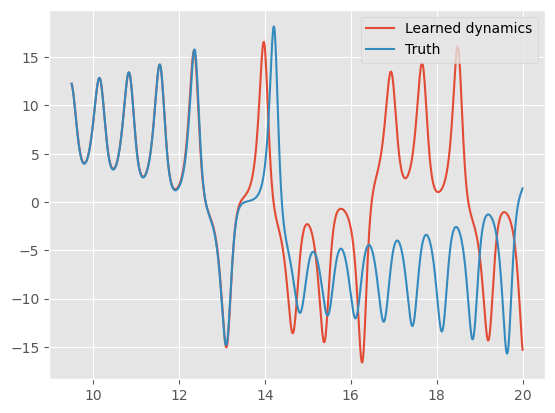

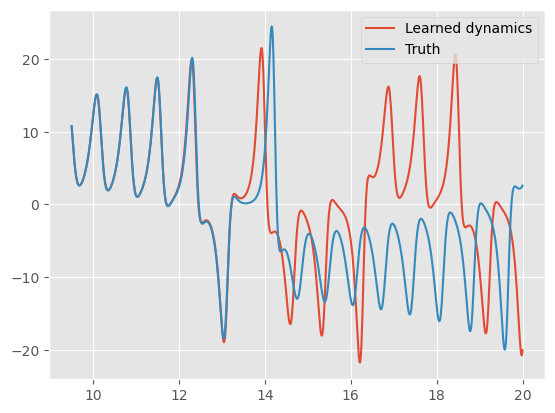

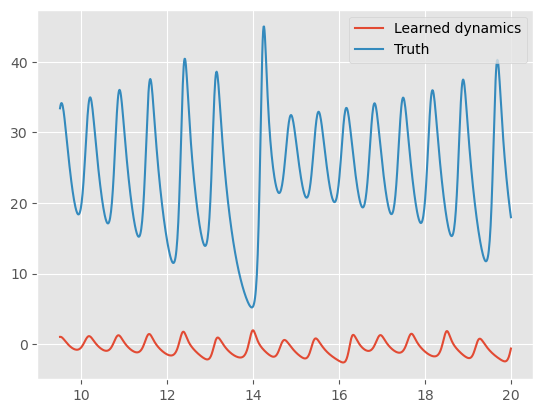

In [51]:
new_grid = jnp.linspace(9.5,20,1000)
new_x = jax.vmap(sol.evaluate)(new_grid)
new_true = jax.vmap(true_sol.evaluate)(new_grid)
for i in range(3):
	plt.plot(new_grid,new_x[:,i],label = "Learned dynamics")
	plt.plot(new_grid,new_true[:,i],label = "Truth")
	plt.legend()
	plt.show()
